In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import os 
import pandas as pd
#if you want to know current working dir
os.getcwd()
os.chdir('/home/jecosine/Courses/Courses/COMP8800/Projects/CatBoostPlayground')
os.listdir()

from allib.datasets import load_uci, AVAIL_DATASETS
from allib.metrics import distance
from allib.utils import ensure_path
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances, check_pairwise_arrays, _precompute_metric_params, effective_n_jobs, _parallel_pairwise, partial, distance as sk_distance

In [4]:
LOCAL_DIR = "examples"

def new_pairwise(X, Y=None, metric="euclidean", n_jobs=None, **kwds):
    # X, Y = check_pairwise_arrays(X, Y, precomputed=False)
    params = _precompute_metric_params(X, Y, metric=metric, **kwds)
    kwds.update(**params)

    if effective_n_jobs(n_jobs) == 1 and X is Y:
        return sk_distance.squareform(sk_distance.pdist(X, metric=metric, **kwds))
    func = partial(sk_distance.cdist, metric=metric, **kwds)

    return _parallel_pairwise(X, Y, func, n_jobs, **kwds)

def normalize(d):
    if d.max() != d.min():
        # normalize to 0 1
        d = (d - d.min()) / (d.max() - d.min())
    return d

def get_dist_mat(dsn: str, encode: str = "ordinal"):
    print("processing dataset ", dsn)
    ds = load_uci(dsn)
    ds.with_preprocess(
        steps=[
            "sample_n", 
            "continuous_only",
            "remove_constant_columns", 
            "drop_duplicate_rows"
        ],  
        params_list=[
            {"n": 1000, "random_state": 0},
            # {"encode": encode}, 
            {},
            {}, 
            {}
        ], 
        in_place=True
    )
    
    # ds.with_preprocess(steps=["sample_n", "continuous_to_categorical", "remove_constant_columns"],  params_list=[{"n": 10000, "random_state": 0}, {"encode": encode}, {}], in_place=True)
    data, label = ds._data, ds._label
    cache_dir = os.path.join(LOCAL_DIR, f"dist_cache_1000/{dsn}")
    # columns = data.columns
    # for c in ds.info["cat_idx"]:
    #     data[columns[c]] = pd.Categorical(data[columns[c]]).codes.astype(int) 
    # check if local cache is available
    ensure_path(cache_dir)
    nks = []
    freq = []
    N = data.shape[0]
    for col in data.columns:
        nks.append(data[col].unique().shape[0])
        freq.append(dict(data[col].value_counts()))
    prob = [{k: v/N for k, v in f.items()} for f in freq]
    prob2 = [{k: (v * (v - 1))/(N * (N-1)) for k, v in f.items()} for f in freq]
    nks = np.array(nks)
    params = {"prob": prob, "prob2": prob2, "nks": nks, "N": N, "freq": freq}
    # use tqdm to show progress
    # for dm in tqdm.tqdm(["euclidean", "cosine"]):
    for dm in tqdm.tqdm(["euclidean", "cosine", "hamming", "smirnov", "goodall1", "iof", "anderberg", "gambaryan"]):
        fn = f"{cache_dir}/{dm}_{encode}.npy"
        if ensure_path(fn, False):
            continue
        d = pairwise_distances(data, metric=distance.get_dist_metric(dm, params), n_jobs=-1)
        if dm not in ["euclidean", "cosine", "hamming"]:
            d = d.max() - d
        # d = normalize(d)
        np.save(fn, d)
    # generate random distance
    # fn = f"{cache_dir}/random_{encode}.npy"
    # if ensure_path(fn, False):
    #     return
    # d = np.random.rand(N, N)
    # np.fill_diagonal(d, 0)
    # np.save(fn, d)
def get_dist_mat_cat_only(dsn: str):
    print("processing dataset ", dsn)
    ds = load_uci(dsn)
    ds.with_preprocess(
        steps=[
            "sample_n", 
            "categorical_only",
            # "remove_constant_columns", 
            # "drop_duplicate_rows"
        ],  
        params_list=[
            {"n": 1000, "random_state": 0},
            {},
            # {}, 
            # {}
        ], 
        in_place=True
    )
    # ds.with_preprocess(steps=["sample_n", "categorical_only", "remove_constant_columns"],  params_list=[{"n": 10000, "random_state": 0}, {}, {}], in_place=True)
    data, label = ds._data, ds._label
    for column in data.columns:
        data[column] = pd.Categorical(data[column]).codes.astype(int) 
    cache_dir = os.path.join(LOCAL_DIR, f"dist_cache_1000/{dsn}")
    # check if local cache is available
    ensure_path(cache_dir)
    nks = []
    freq = []
    N = data.shape[0]
    for col in data.columns:
        nks.append(data[col].unique().shape[0])
        freq.append(dict(data[col].value_counts()))
    prob = [{k: v/N for k, v in f.items()} for f in freq]
    prob2 = [{k: (v * (v - 1))/(N * (N-1)) for k, v in f.items()} for f in freq]
    nks = np.array(nks)
    params = {"prob": prob, "prob2": prob2, "nks": nks, "N": N, "freq": freq}
    # use tqdm to show progress
    
    print(data.shape[0])
    # for dm in tqdm.tqdm(distance.AVAIL_DIST_METRICS):
    for dm in tqdm.tqdm(["gambaryan"]):
        # if dm not in ["euclidean", "cosine", "hamming"]:
        #     continue
        fn = f"{cache_dir}/{dm}_catonly_wid.npy"
        if ensure_path(fn, False):
            continue
        d = pairwise_distances(data, metric=distance.get_dist_metric(dm, params), n_jobs=-1)
        if dm not in ["euclidean", "cosine", "hamming"]:
            d = d.max() - d
        # d = squareform(pdist(data, metric=distance.get_dist_metric(dm, params)))
        # d = normalize(d)
        print(d.shape)
        np.save(fn, d)
    # generate random distance
    # fn = f"{cache_dir}/random_catonly_wo_n.npy"
    # if ensure_path(fn, False):
    #     return
    # d = np.random.rand(N, N)
    # np.fill_diagonal(d, 0)
    # np.save(fn, d)

In [41]:
data.shape[0]

NameError: name 'data' is not defined

In [10]:
for dsn in ["adult"]:
    # if dsn == "adult" or dsn == "balance-scale":
    #     continue
    get_dist_mat_cat_only(dsn)

processing dataset  adult
1000


100%|██████████| 1/1 [00:33<00:00, 33.07s/it]

(1000, 1000)


In [5]:
for dsn in ["adult"]:
    # if dsn == "adult" or dsn == "letter-recognition":
    #     continue
    get_dist_mat(dsn, "numerical")

processing dataset  adult


100%|██████████| 8/8 [07:29<00:00, 56.14s/it]


In [6]:
get_dist_mat("adult", "onehot-dense")

processing dataset  adult


/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the numbe

In [23]:
from sklearn.preprocessing import KBinsDiscretizer
params = {
    "encode": "onehot-dense",
    # "encode": "ordinal",
}
kbin = KBinsDiscretizer(**params)
ds = load_uci("iris")
data = ds._data
disc = kbin.fit_transform(data)


In [22]:
new_data = pd.DataFrame(disc, columns=kbin.get_feature_names_out(), index=data.index)
for col in new_data.columns:
    new_data[col] = new_data[col].astype("category").cat.codes
    new_data[col] = new_data[col].astype(int).astype("category")
pd.get_dummies(new_data)
# new_data

,sepal_length_0,sepal_length_1,sepal_length_2,sepal_length_3,sepal_length_4,sepal_width_0,sepal_width_1,sepal_width_2,sepal_width_3,sepal_width_4,petal_length_0,petal_length_1,petal_length_2,petal_length_3,petal_length_4,petal_width_0,petal_width_1,petal_width_2,petal_width_3,petal_width_4
0,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False
1,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False
2,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False
3,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False
4,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
148,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True
149,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False
184,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False


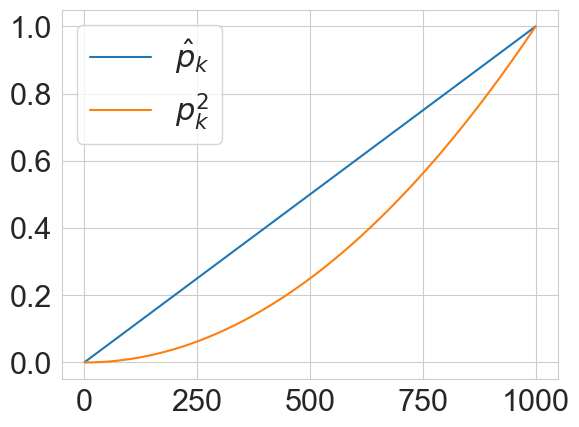

In [40]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(1, 1001.0)
# increase font size
plt.rcParams.update({'font.size': 22})
plt.plot(x, x/1000.0, label=r'$\hat{p}_k$')
plt.plot(x, x * (x-1)/(1000 * 999), label=r'$p^2_k$')
plt.legend()